In [74]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import scipy.stats as stats
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import csv

Populating the interactive namespace from numpy and matplotlib


In [75]:
# -- Variable Dictionary --

# Constants
omega_k = 0                     # critical density
c = 2.9979e5                    # speed of light (km/s)
omega_l = None                  # energy density
pressure = 0.0                  # pressure of the universe

# Parameters we are trying to find
omega_m = None                  # mass density parameter
w = None                        # equation of state
dm_offset = None                # offset of the model from the data

# Variable dictionary
H = None                        # Hubble constant (km/s/Mpc)
z = None                        # redshift
D_C = None                      # comoving distance, line-of-sight (m)
D_M = None                      # comoving distance, transverse (m)
D_A = None                      # angular diameter distance (m)
D_L = None                      # luminosity distance (m)
V_C = None                      # comoving volume (m^3)
D_H = None                      # Hubble Distance (Mpc)
array_size = None               # size of each array, which is the number of z values
param_text = ""                 # label for the plots
npts = None                     # Number of points (omega_m, w) we use

# Calculate Hubble distance
H = 70.0                        # Hubble constant
D_H = c / H                     # Hubble distance

# -------------------------------------------------------------------------------------------------------

# -- Function Dictionary --

# Calculate E(z), which in this situation depends on w
def E(z_i, w, omega_m, omega_l):
    omega_k = 1.0 - omega_m - omega_l
    # Assume a flat universe, i.e. omega_k = 0
    omega_k = 0.0
    inside = omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l * (1.0+z_i)**(3.0*(1.0+w))
    if (inside < 0):
        print("inside = " + str(inside))
        print("omega_m = " + str(omega_m))
        print("omega_k = " + str(omega_k))
        print("omega_l = " + str(omega_l))
        print("w = " + str(w))
        print("z_i = " + str(z_i))
    inside = abs(inside)
    E = np.sqrt(inside)
    return E

# Calculate the integral D_C/D_H, store it in an array
def DCDH_int(z_limit, w, omega_m, omega_l):
    f = lambda z_i: 1.0 / E(z_i, w, omega_m, omega_l)
    i = integrate.quad(f, 0, z_limit)
    return i[0]

# -----------------------------------------------------------------------------------

# Proper Motion distance integrals

# proper motion distance for omega_l == 0
def prop_motion_0(z, w, omega_m, omega_l):

    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    # Continuing our flat universe assumption, we have
    omega_k = 0.0

    # Calculate D_M/D_H for different universe geometries
    # open universe (omega_k > 0)
    if (omega_k > 1.0e-6):
        return 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z,w,omega_m,omega_l) )
    # closed universe (omega_k < 0)
    elif (omega_k < -1.0e-6):
        return 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z,w,omega_m,omega_l) )
    # flat universe (omega_k = 0)
    else:
        return 2.0*( 2.0 - omega_m*(1.0-z) - (2-omega_m)*np.sqrt(1.0+omega_m*z) ) / ( omega_m*omega_m*(1.0+z) )

# proper motion distance for omega_l != 0
def prop_motion(z, w, omega_m, omega_l):
        
    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    # Continuing our flat universe assumption, we have
    omega_k = 0.0
    
    # Calculate D_C/D_H integral
    DCDH = DCDH_int(z,w,omega_m,omega_l)
    
    # Calculate D_M/D_H for different universe geometries
    # open universe
    if (omega_k > 1.0e-6):
        return 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH )
    # closed universe
    elif (omega_k < -1.0e-6):
        return 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH )
    # flat universe
    else:
        return DCDH

# --------------------------------------------------------------------------------------------

# distance modulus

def dist_mod(z, D_H, omega_m, omega_l, DMDH):
    
    # initialize the distance modulus value
    mu = 0.0
    
    # convert D_H from Mpc to pc
    DH = D_H * 1.0e6
    
    # Determine D_M/D_H
    if (omega_l == 0):
        DMDH = prop_motion_0(z, w, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, w, omega_m, omega_l)

    # calculate each value of mu array
    #for i in range(len(z)):
        #mu[i] = 5.0 * ( np.log10(1.0+z[i]) + np.log10(DCDH_int(z[i], omega_m, omega_l)) + np.log10(D_H/10) )
    mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
    
    return mu

In [76]:
# Begin by collecting csv data and making a scatter plot of it
zs = []
dm_obs = []
sigmas = []

with open('ps1_data.txt', newline='') as csvfile:
    ps1_data = csv.reader(csvfile, delimiter=' ')
    i = 0
    for row in ps1_data:
        if (i > 0):
            zs.append(float(row[1]))
            dm_obs.append(float(row[4]))
            sigmas.append(float(row[5]))
        i+= 1
csvfile.close()
        
#plt.scatter(zs, dm_obs)
#print('z\tdm')
#for z, dm in zip(zs, dm_obs):
#    print('{:.3f}\t{:.3f}'.format(z, dm))

In [79]:
# -- Proposal and log likelihood functions defined --

# proposal function q(x'|x) where x is a 3D vector
def q(x):
    # ------------------------------------------------------------------------------------
    
    # draw x' from a multivariate gaussian with mean [0,0,0] and covariance matrix I
    # Add the randomly drawn number to x and return the sum
    mu = np.array([0.0, 0.0, 0.0])
    a = rand() - 0.5
    b = rand() - 0.5
    c = rand() - 0.5
    #sigma = np.matrix([ [a/10.0,0.0,0.0], [0.0,b/10.0,0.0], [0.0,0.0,c/10.0] ])    # covariance matrix
    sigma = 1.0
    x1,y1,z1 = stats.multivariate_normal(mean=mu, cov=sigma, 5000).T
    print("x1 = " + str(x1))
    print("y1 = " + str(y1))
    print("z1 = " + str(z1))
    q = stats.multivariate_normal.rvs(mean=mu, cov=sigma)
    
    print("q = " + str(q))
    r = x + q
    
    # Resulting matter density component r[0] should be between 0 and 1
    if (r[0] > 1.0):
        r[0] = 1.0
    elif (r[0] < 0.0):
        r[0] = 0.0
    return r

# ---------------------------------------------------------------------------------------------------------

# density function f(x) is the log likelihood of the data given parameters
# takes a vector x = (x1, x2) as input
def make_log_likelihood(zs, dm_obs, sigmas, D_H):
    
    def log_likelihood(omega_m, w, dm_offset):
        
        # Assume a flat universe, i.e. omega_l = 1 - omega_m, or omega_k = 0
        omega_l = 1.0 - omega_m
                
        # initialize the log likelihood function
        ln_likelihood = 0.0

        # loop for all values of z in the z-array
        for i in range(len(zs)):
            
            # initialize for each iteration
            z_i = zs[i]
            sigma_dm_i = sigmas[i]
            dm_obs_i = dm_obs[i]
            
            # calculate predicted value of distance modulus based on z-value and parameters
            # predicted = [distance modulus calculation] + offset
            DMDH_i = prop_motion(z_i, w, omega_m, omega_l)    # proper motion distance
            dm_pred_i = dist_mod(z_i, D_H, omega_m, omega_l, DMDH_i) + dm_offset    # distance modulus

            # calculate each term
            term = np.log(1.0 / (sigma_dm_i*np.sqrt(2.0*np.pi))) \
            - 0.5 * (dm_obs_i-dm_pred_i) * (dm_obs_i-dm_pred_i) / (sigma_dm_i*sigma_dm_i)

            # increment log-likelihood
            ln_likelihood += term

            # print statement to debug code
            #print("x: " + str(xi) + " | sigma: " + str(sigma_i) + " | Term being added: " + str(term))
            
        return ln_likelihood
        
    return log_likelihood

SyntaxError: positional argument follows keyword argument (<ipython-input-79-3ee9f5e2a1c7>, line 23)

In [78]:
# -- Run MCMC --

# Create the lnf function
lnf = make_log_likelihood(zs, dm_obs, sigmas, D_H)

# Markov chain
mchain = [[0.5,-1.0,20.0]]    # array of omega_m, w, and dm_offset values

for i in range(200):
    
    # Take the last entry in the Markov chain
    params = mchain[-1]
    
    omega_m = params[0]
    w = params[1]
    dm_offset = params[2]

    # propose a new point in the parameter space
    params_new = q(params)
    
    omega_m_new = params_new[0]
    w_new = params_new[1]
    dm_offset_new = params_new[2]
    
    print("i = " + str(i))
    print("params = " + str(params))
    print("params_new = " + str(params_new))
    print()
    print("omega_m = " + str(omega_m) + " | w = " + str(w) + " | dm_offset = " + str(dm_offset))
    print("omega_m_new = " + str(omega_m_new) + " | w_new = " + str(w_new) + " | dm_offset_new = " + str(dm_offset_new))
    print()
    # log likelihood is always negative. If lnf_new is greater than lnf_old, then accept_diff is positive
    lnf_new = lnf(omega_m_new, w_new, dm_offset_new)
    lnf_old = lnf(omega_m, w, dm_offset)
    accept_diff = lnf_new - lnf_old
    print("lnf old: " + str(lnf_old))
    print("lnf new: " + str(lnf_new))
    print("accept_diff = " + str(accept_diff))
    
    # accept if the accept_diff is greater than a randomly selected value from 1 to e, reject otherwise
    benchmark = np.log(rand())
    if benchmark < accept_diff:
        mchain.append(params_new)
    else:
        mchain.append(params)
    # Problem: At some point, it gets to where the acceptance difference is 
    
    #if (i % 20 == 0):
    #    print("i = " + str(i))
    
    # print a line to separate results of each iteration
    print()
    print("-----------")
    print()
        
print("Finished MCMC")

TypeError: cannot unpack non-iterable multivariate_normal_frozen object

In [71]:
# Extract V- and R-coordinates from the array of vectors
omegams = []    # list of omega_m values
ws = []         # list of w values
offsets = []    # list of dm offsets

for i in mchain:
    omegams.append(i[0])
    ws.append(i[1])
    offsets.append(i[2])
    #print("length of each array: " + str(len(omegams)))
    # Variation of the loop: use an if statement to omit burn-in points
    #for i in VRs:
    #

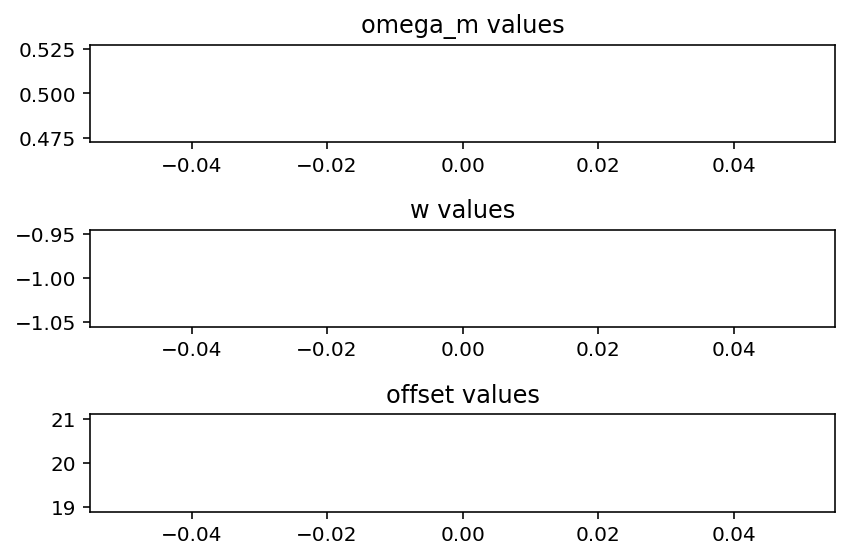

In [72]:
# Trace the evolution of V and R values over iterations
subplot(311)
title('omega_m values')
plot(omegams)

subplot(312)
title('w values')
plot(ws)

subplot(313)
title('offset values')
plot(offsets)

tight_layout()

show()

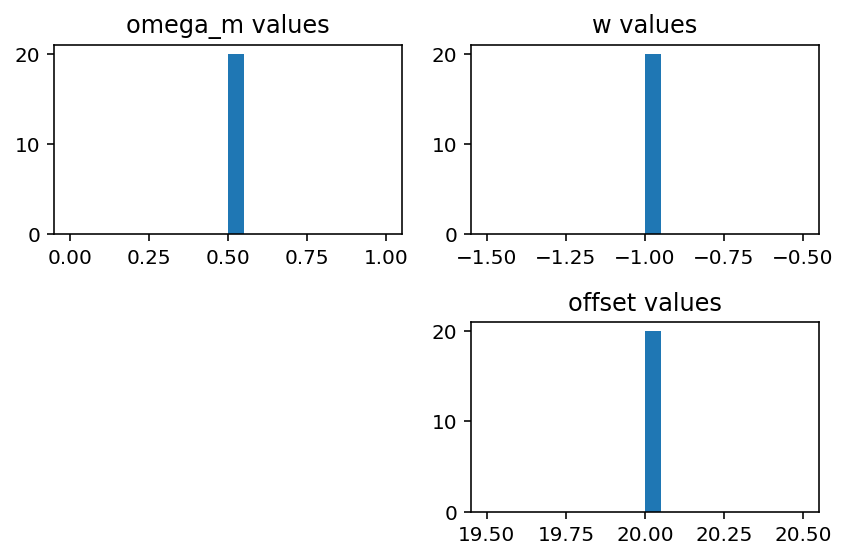

In [73]:
    
# Generate 1-dimensional histograms of parameter values
subplot(221)
title('omega_m values')
hist(omegams, density=True, bins=20)

subplot(222)
title('w values')
hist(ws, density=True, bins=20)

subplot(224)
title('offset values')
hist(offsets, density=True, bins=20)

#subplot(223)
#title('R vs V')
#scatter(Vs, Rs)
#plt.xlabel('V')
#plt.ylabel('R')

tight_layout()

show()